<a href="https://colab.research.google.com/github/hanselkane/DataAnalytics/blob/main/Hansel_Astro_Sr_Data_Analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inventory prediction**
# Hansel Kane - Sr. Data Analyst (Astro)

Hi, my name is Hansel. This notebook which is a part of Astro recruitment process consists of 2 parts. The main part is the part 2 (point 3 in the assignment document) which is about inventory prediction. The other part is part 1 where I do aggregate analysis.

## Setup

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%load_ext google.cloud.bigquery
%load_ext google.colab.data_table

In [ ]:
!pip3 install --upgrade google-cloud-bigquery

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

## Setup bigquery

In [5]:
from google.cloud import bigquery
project_id = 'astroproject-431113'
client = bigquery.Client(project_id)

In [6]:
import bigframes.pandas as bpd
bpd.options.bigquery.project = project_id

In [ ]:
bpd.option_context("display.max_rows", 1000)

# Exploratory Data Analysis

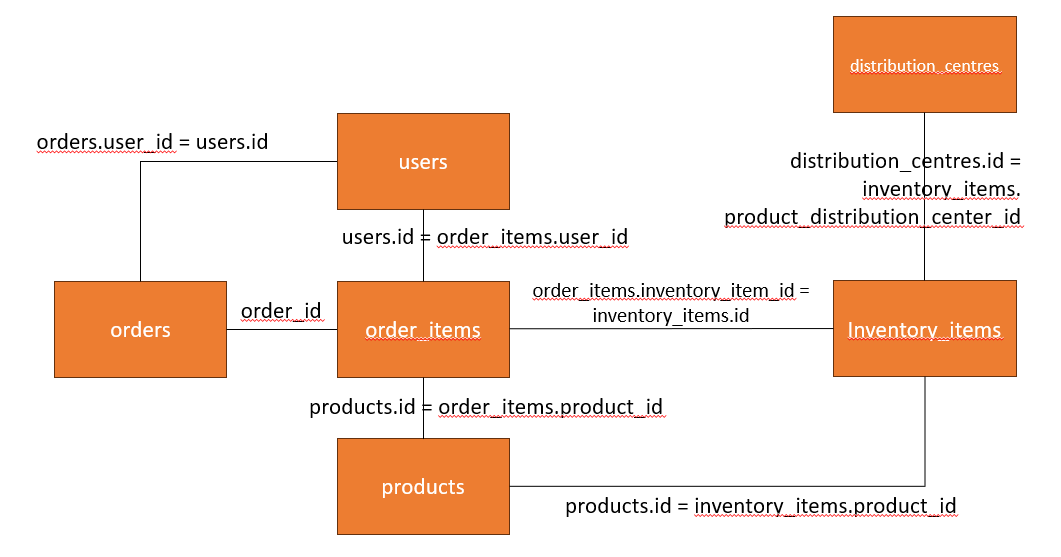

## Inspect Inventory

In [356]:
q = """
WITH total_inventory AS (
  SELECT
    p.name,
    p.category,
    COUNT(*) AS productCount
  FROM bigquery-public-data.thelook_ecommerce.inventory_items ii
  JOIN bigquery-public-data.thelook_ecommerce.products p
  ON ii.product_id = p.id
  GROUP BY p.name, p.category
),
sold_inventory AS (
  SELECT
    p.name,
    p.category,
    COUNT(*) AS productCount
  FROM bigquery-public-data.thelook_ecommerce.inventory_items ii
  JOIN bigquery-public-data.thelook_ecommerce.products p
  ON ii.product_id = p.id
  WHERE sold_at IS NOT NULL
  GROUP BY p.name, p.category
)

SELECT
  t.name,
  t.category,
  t.productCount as totalInventory,
  s.productCount as soldInventory,
  (s.productCount / t.productCount) * 100 AS soldPercent
FROM total_inventory t
JOIN sold_inventory s
ON t.name = s.name
"""

bq_df = bpd.read_gbq(q)
bq_df.sort_values('totalInventory', ascending=False).head()

,name,category,totalInventory,soldInventory,soldPercent
18089,Wrangler Men's Premium Performance Cowboy Cut ...,Jeans,117,47,40.17094
4960,Silver Jeans Men's Zac Relaxed Fit Jean,Jeans,94,35,37.234043
28260,7 For All Mankind Men's Standard Classic Strai...,Jeans,89,29,32.58427
18260,True Religion Men's Ricky Straight Jean,Jeans,86,30,34.883721
10469,Puma Men's Socks,Socks,82,29,35.365854


In [357]:
q = """
WITH total_inventory AS (
  SELECT
    p.name,
    p.category,
    COUNT(*) AS productCount
  FROM bigquery-public-data.thelook_ecommerce.inventory_items ii
  JOIN bigquery-public-data.thelook_ecommerce.products p
  ON ii.product_id = p.id
  GROUP BY p.name, p.category
),
sold_inventory AS (
  SELECT
    p.name,
    p.category,
    COUNT(*) AS productCount
  FROM bigquery-public-data.thelook_ecommerce.inventory_items ii
  JOIN bigquery-public-data.thelook_ecommerce.products p
  ON ii.product_id = p.id
  WHERE sold_at IS NOT NULL
  GROUP BY p.name, p.category
)

SELECT
  t.category,
  COUNT(*) as productCount
FROM total_inventory t
GROUP BY 1
"""

bq_df = bpd.read_gbq(q)
bq_df.sort_values('productCount', ascending=False).head()

,category,productCount
5,Intimates,2330
12,Tops & Tees,1844
21,Fashion Hoodies & Sweatshirts,1838
15,Jeans,1822
8,Swim,1770


In [358]:
q = """
SELECT
  p.name,
  ii.product_name,
  ii.product_brand
FROM bigquery-public-data.thelook_ecommerce.inventory_items ii
JOIN bigquery-public-data.thelook_ecommerce.products p
ON ii.product_id = p.id
"""

bq_df = bpd.read_gbq(q)
bq_df.head()

,name,product_name,product_brand
0,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's
1,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's
2,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's
3,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's
4,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's Juniors 524 Styled Skinny Complement Jean,Levi's


## Inspect countries

In [193]:
q = """
SELECT
  country,
  COUNT(*) AS counts
FROM bigquery-public-data.thelook_ecommerce.users u
GROUP BY country
ORDER BY counts DESC
"""

bq_df = bpd.read_gbq(q)
bq_df = bq_df.sort_values(by=['counts'], ascending=False).reset_index()
bq_df

,index,country,counts
0,5,China,33905
1,9,United States,22634
2,10,Brasil,14568
3,3,South Korea,5426
4,12,France,4658
5,13,United Kingdom,4598
6,1,Germany,4169
7,8,Spain,3958
8,7,Japan,2467
9,6,Australia,2095


In [359]:
### Find location of users of each distribution centres

q = """
SELECT
  dc.name as distributorName,
  u.country,
  COUNT(*) as eventCount
FROM bigquery-public-data.thelook_ecommerce.distribution_centers dc
JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
ON ii.product_distribution_center_id = dc.id
JOIN bigquery-public-data.thelook_ecommerce.order_items oi
ON ii.id = oi.inventory_item_id
JOIN bigquery-public-data.thelook_ecommerce.users u
ON oi.user_id = u.id
GROUP BY 1, 2
"""

bq_df = bpd.read_gbq(q)
bq_df.sort_values('distributorName', ascending=False).head()

,distributorName,country,eventCount
29,Savannah GA,Belgium,146
43,Savannah GA,Australia,248
44,Savannah GA,France,514
47,Savannah GA,Spain,465
77,Savannah GA,Colombia,1


## Inspect order_items and inventory_items

In [9]:
# Raw X
q = """
WITH fact_orders AS (
  SELECT
    MIN(oi.shipped_at) AS min_oi_shipped,
    MAX(oi.shipped_at) AS max_oi_shipped
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE ii.sold_at IS NOT NULL
)

SELECT * FROM fact_orders
"""

X = bpd.read_gbq(q)
print(X.columns)
X.head()

# Items with NON NULL sold_at don't have shipped_at date

Index(['min_oi_shipped', 'max_oi_shipped'], dtype='object')


,min_oi_shipped,max_oi_shipped
0,<NA>,<NA>


## Find auto-correlation

Find auto-correlation between days

In [ ]:
# Crawl data of sales per day
### Find location of users of each distribution centres

q = """
SELECT
  CAST(EXTRACT(YEAR FROM sold_at) AS INT) as soldYear,
  CAST(EXTRACT(MONTH FROM sold_at) AS INT) as soldMonth,
  CAST(EXTRACT(DAY FROM sold_at) AS INT) as soldDay,
  COUNT(*) as eventCount
FROM bigquery-public-data.thelook_ecommerce.inventory_items
WHERE sold_at IS NOT NULL
GROUP BY 1,2,3
LIMIT 3000
"""

bq_df = bpd.read_gbq(q)
bq_df = bq_df.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
bq_df

,index,soldYear,soldMonth,soldDay,eventCount
0,797,2019,1,7,1
1,1480,2019,1,14,1
2,711,2019,1,15,1
3,268,2019,1,16,2
4,1253,2019,1,18,1
5,540,2019,1,20,2
6,770,2019,1,26,1
7,352,2019,1,28,1
8,1801,2019,1,31,1
9,98,2019,2,2,2


<Axes: xlabel='None', ylabel='eventCount'>

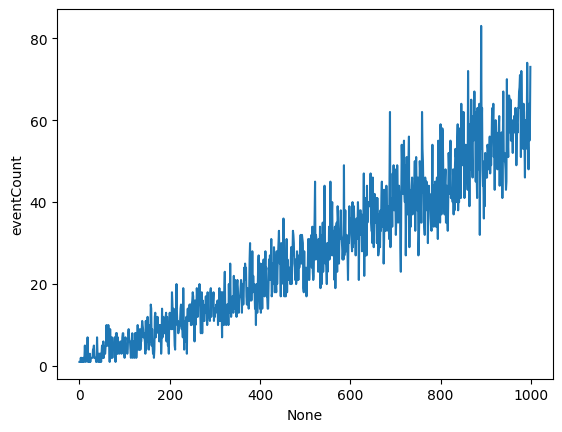

In [ ]:
import seaborn as sns
df = bq_df.to_pandas()
sns.lineplot(data=df[:1000], x=df.index[:1000], y="eventCount")

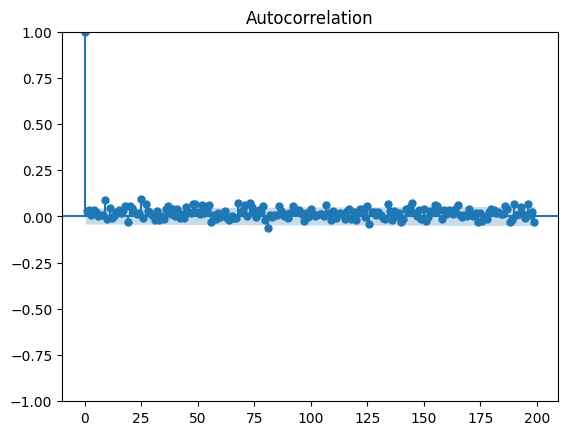

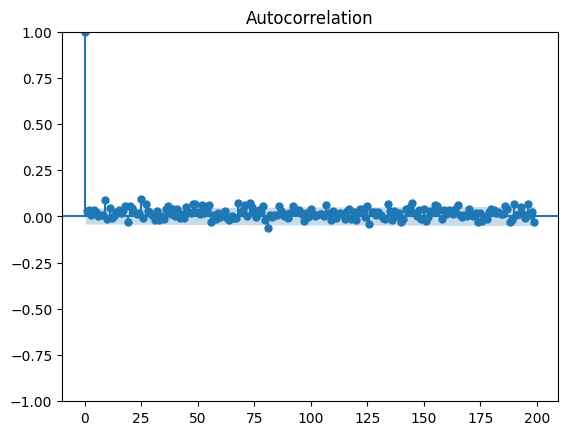

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

lagsInput=np.arange(200)
plot_acf(bq_df['eventCount'], lags=lagsInput)

# Part 1

## Table Fact Orders

In [366]:
# Raw X
q = """
WITH fact_orders AS (
  SELECT
    oi.status AS oi_status,
    oi.created_at AS oi_created_at,
    oi.shipped_at AS oi_shipped_at,
    oi.delivered_at AS oi_delivered_at,
    oi.returned_at AS oi_returned_at,
    oi.sale_price,
    ii.created_at AS ii_created_at,
    ii.sold_at AS ii_sold_at,
    ii.cost AS ii_cost,
    ii.product_category,
    ii.product_retail_price,
    ii.product_department,
    u.email,
    u.age,
    u.gender,
    u.state AS u_state,
    u.city AS u_city,
    u.country AS u_country,
    u.traffic_source AS u_traffic_source
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
)

SELECT * FROM fact_orders
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['email'], ascending=[True]).reset_index()
print(X.columns)
X.head()

Index(['index', 'oi_status', 'oi_created_at', 'oi_shipped_at',
       'oi_delivered_at', 'oi_returned_at', 'sale_price', 'ii_created_at',
       'ii_sold_at', 'ii_cost', 'product_category', 'product_retail_price',
       'product_department', 'email', 'age', 'gender', 'u_state', 'u_city',
       'u_country', 'u_traffic_source'],
      dtype='object')


,index,oi_status,oi_created_at,oi_shipped_at,oi_delivered_at,oi_returned_at,sale_price,ii_created_at,ii_sold_at,ii_cost,product_category,product_retail_price,product_department,email,age,gender,u_state,u_city,u_country,u_traffic_source
0,45621,Cancelled,2022-02-20 09:26:23+00:00,<NA>,<NA>,<NA>,19.540001,2022-05-01 14:37:00+00:00,<NA>,11.255041,Fashion Hoodies & Sweatshirts,19.540001,Men,aaronadams@example.org,45,M,Hunan,Dongguan,China,Search
1,148643,Shipped,2024-04-27 06:42:42+00:00,2024-04-28 16:26:00+00:00,<NA>,<NA>,90.0,2024-02-08 14:54:00+00:00,<NA>,42.84,Sweaters,90.0,Men,aaronadams@example.org,45,M,Hunan,Dongguan,China,Search
2,64283,Processing,2024-02-04 07:50:36+00:00,<NA>,<NA>,<NA>,297.0,2020-01-24 04:07:00+00:00,<NA>,131.571,Suits & Sport Coats,297.0,Men,aaronalexander@example.net,59,M,Seoul,Seoul,South Korea,Search
3,48974,Shipped,2024-03-04 05:53:45+00:00,2024-03-04 16:36:00+00:00,<NA>,<NA>,20.950001,2020-05-20 18:02:00+00:00,<NA>,9.49035,Underwear,20.950001,Men,aaronali@example.org,49,M,Tianjin,Fuyang,China,Organic
4,89487,Shipped,2024-03-07 04:21:10+00:00,2024-03-04 16:36:00+00:00,<NA>,<NA>,54.5,2022-09-25 16:44:00+00:00,<NA>,31.392,Swim,54.5,Men,aaronali@example.org,49,M,Tianjin,Fuyang,China,Organic


## Monthly orders country aggregate

In [15]:
q = """
WITH fact_orders AS (
  SELECT
    oi.delivered_at AS oi_delivered_at,
    u.country AS u_country
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.delivered_at IS NOT NULL
    AND oi.status = 'Complete'
)

SELECT
  EXTRACT(YEAR FROM oi_delivered_at) as soldYear,
  EXTRACT(MONTH FROM oi_delivered_at) as soldMonth,
  u_country,
  COUNT(*) as eventCount
FROM fact_orders
WHERE EXTRACT(YEAR FROM oi_delivered_at) = 2024
  AND EXTRACT(MONTH FROM oi_delivered_at) IN (5,6,7)
GROUP BY 1,2,3
"""

df = bpd.read_gbq(q)
df.head()
# Pie chart for 2024: month 7(31),6(30),5(31)

,soldYear,soldMonth,u_country,eventCount
0,2024,6,France,109
1,2024,6,Poland,5
2,2024,5,United States,509
3,2024,5,China,763
4,2024,5,France,96


In [20]:
import plotly.express as px

for i in range(5,8):
  title = ""
  if i==5:
      title = "Items delivered by countries - May 2024"
  elif i==6:
      title = "Items delivered by countries - June 2024"
  elif i==7:
      title = "Items delivered by countries - July 2024"
  fig = px.pie(df[df['soldMonth']==i], values='eventCount', names='u_country', title=title)
  fig.show()

## Monthly orders product aggregate

In [25]:
q = """
WITH fact_orders AS (
  SELECT
    oi.delivered_at AS oi_delivered_at,
    ii.product_name
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.delivered_at IS NOT NULL
    AND oi.status = 'Complete'
),
raw AS (
  SELECT
    EXTRACT(YEAR FROM oi_delivered_at) as soldYear,
    EXTRACT(MONTH FROM oi_delivered_at) as soldMonth,
    product_name,
    COUNT(*) as eventCount
  FROM fact_orders
  WHERE EXTRACT(YEAR FROM oi_delivered_at) = 2024
    AND EXTRACT(MONTH FROM oi_delivered_at) IN (5,6,7)
  GROUP BY 1,2,3
),
limiter AS (
  SELECT
    *,
    ROW_NUMBER() OVER(PARTITION BY soldYear, soldMonth ORDER BY eventCount DESC) AS rnk
  FROM raw
)

SELECT * EXCEPT(rnk) FROM limiter
WHERE rnk <= 10
"""

df = bpd.read_gbq(q)
df.head()
# Pie chart for 2024: month 7(31),6(30),5(31)

,soldYear,soldMonth,product_name,eventCount
0,2024,7,American Apparel Unisex Wool Blend Fingerless ...,3
1,2024,6,Indiana Jones Crushable Wool Felt Fedora Hats ...,2
2,2024,5,Pendleton Men's Outback Hat,2
3,2024,5,Best PILOT TROOPER Brown Shell AVIATOR Faux Le...,2
4,2024,6,FAUX LEATHER SNAP ON BLACK STUDDED BELT FITS A...,2


In [26]:
import plotly.express as px

for i in range(5,8):
  title = ""
  if i==5:
      title = "Top 10 items delivered by product name - May 2024"
  elif i==6:
      title = "Top 10 items delivered by product name - June 2024"
  elif i==7:
      title = "Top 10 items delivered by product name - July 2024"
  fig = px.pie(df[df['soldMonth']==i], values='eventCount', names='product_name', title=title)
  fig.show()

# Part 2

# Data processing

## Process X

In [ ]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-08-06', INTERVAL 30 DAY))) AS dates
)

SELECT
  EXTRACT(YEAR FROM p.dates) as soldYear,
  EXTRACT(MONTH FROM p.dates) as soldMonth,
  EXTRACT(DAY FROM p.dates) as soldDay,
  soldTotalUser,
  soldTotalEvent,
  soldTotalRetailPrice
FROM placeholder p
LEFT JOIN raw
ON p.dates = raw.soldDate
# WHERE soldTotalEvent IS NULL OR soldTotalEvent = 0
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X.drop(columns=['index'])

# X = X['soldTotalEvent']
print(X)

    soldYear  soldMonth  soldDay  soldTotalUser  soldTotalEvent  \
0       2019          1       12           <NA>            <NA>   
1       2019          1       13           <NA>            <NA>   
2       2019          1       14              1               1   
3       2019          1       15           <NA>            <NA>   
4       2019          1       16           <NA>            <NA>   
5       2019          1       17           <NA>            <NA>   
6       2019          1       18           <NA>            <NA>   
7       2019          1       19           <NA>            <NA>   
8       2019          1       20           <NA>            <NA>   
9       2019          1       21           <NA>            <NA>   
10      2019          1       22           <NA>            <NA>   
11      2019          1       23           <NA>            <NA>   
12      2019          1       24           <NA>            <NA>   
13      2019          1       25              1               

In [ ]:
import numpy as np

X = np.array(X.to_pandas().astype(float))

X_columize = []

# for i in range(len(X)):
for i in range(len(X)-30):
  row = []
  for day in range(30):
    row=np.concatenate((row, X[i+day]), axis=None)
  X_columize.append(row)

print("X_columize created")
array = np.array(X_columize)
print(array.shape)

X_columize created
(1974, 180)


## Process **Y**

In [151]:
# Raw Y
# Extract Y starting from '2019-01-12' + 30 days until MAX('2024-08-06') - 30, step = 1 day, total days = 30

q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    EXTRACT(YEAR FROM oi.shipped_at) as soldYear,
    EXTRACT(MONTH FROM oi.shipped_at) as soldMonth,
    EXTRACT(DAY FROM oi.shipped_at) as soldDay,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
  GROUP BY soldDate, soldYear, soldMonth, soldDay
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-08-06', INTERVAL 30 DAY))) AS dates
)

SELECT
  p.dates as anchor_date,
  SUM(raw.soldTotalEvent) as productSoldNextMonth
FROM placeholder p
LEFT JOIN raw
ON (raw.soldDate BETWEEN DATE_ADD(p.dates, INTERVAL 30 DAY) AND DATE_ADD(p.dates, INTERVAL 60 day))
GROUP BY 1
# HAVING productSoldNextMonth IS NULL
"""

Y = bpd.read_gbq(q)
Y = Y.sort_values(by=['anchor_date'], ascending=True).reset_index()
print(Y)
Y = Y.drop(columns=['index','anchor_date'])

    index anchor_date  productSoldNextMonth
0    1445  2019-01-12                    56
1     594  2019-01-13                    55
2    1183  2019-01-14                    56
3    1122  2019-01-15                    56
4    1221  2019-01-16                    52
5     783  2019-01-17                    51
6    1367  2019-01-18                    53
7    1636  2019-01-19                    52
8     113  2019-01-20                    53
9    1615  2019-01-21                    58
10    223  2019-01-22                    60
11     48  2019-01-23                    64
12    571  2019-01-24                    63
13    774  2019-01-25                    65
14    257  2019-01-26                    66
15    682  2019-01-27                    65
16   1027  2019-01-28                    74
17    624  2019-01-29                    72
18   1792  2019-01-30                    71
19    394  2019-01-31                    64
20   1219  2019-02-01                    66
21    788  2019-02-02           

In [152]:
# Truncate Y
Y = np.array(Y.to_pandas().astype(float))
Y = Y[:1974]

## Train-Validation-Test split


In [ ]:
# Train test split
# Train=1500 data; Validation = 200; Test = 274
X_train = X_columize[:1500]
X_valid = X_columize[1500:1700]
X_test = X_columize[1700:]

Y_train = Y[:1500]
Y_valid = Y[1500:1700]
Y_test = Y[1700:]

# Machine Learning

In [ ]:
# Import all libraries
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## XGBoost

### Train

In [ ]:
# Train the model
model=xgb.XGBRegressor(
    max_depth=5,
    n_estimators=80,
)

# model.fit(X_train, Y_train, verbose=True)
model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True)

[0]	validation_0-rmse:468.16462	validation_1-rmse:1560.59384
[1]	validation_0-rmse:331.03114	validation_1-rmse:1287.24995
[2]	validation_0-rmse:234.48103	validation_1-rmse:1093.41486
[3]	validation_0-rmse:166.61055	validation_1-rmse:957.77396
[4]	validation_0-rmse:119.13191	validation_1-rmse:864.80063
[5]	validation_0-rmse:85.97214	validation_1-rmse:793.05577
[6]	validation_0-rmse:62.51364	validation_1-rmse:740.09594
[7]	validation_0-rmse:46.40837	validation_1-rmse:698.94378
[8]	validation_0-rmse:35.13550	validation_1-rmse:663.66823
[9]	validation_0-rmse:27.53560	validation_1-rmse:638.41127
[10]	validation_0-rmse:22.37578	validation_1-rmse:618.60690
[11]	validation_0-rmse:18.96816	validation_1-rmse:605.67210
[12]	validation_0-rmse:16.76768	validation_1-rmse:595.73711
[13]	validation_0-rmse:15.27552	validation_1-rmse:587.95584
[14]	validation_0-rmse:14.17652	validation_1-rmse:578.20632
[15]	validation_0-rmse:13.29403	validation_1-rmse:575.23834
[16]	validation_0-rmse:12.68554	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Training evaluation

In [ ]:
# Evaluate model performance using validation set
y_valid_pred = model.predict(X_valid)

# Compute evaluation metrics
mse = mean_squared_error(Y_valid, y_valid_pred)
mae = mean_absolute_error(Y_valid, y_valid_pred)
mape = mean_absolute_percentage_error(Y_valid,y_valid_pred)
r2 = r2_score(Y_valid, y_valid_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 312306.0489090082
Mean Absolute Error: 500.30635131835936
Mean Absolute Percentage Error: 16.474347123330254
R^2 Score: -3.259303277442135


len Y_valid:  200
len y_valid_pred:  200


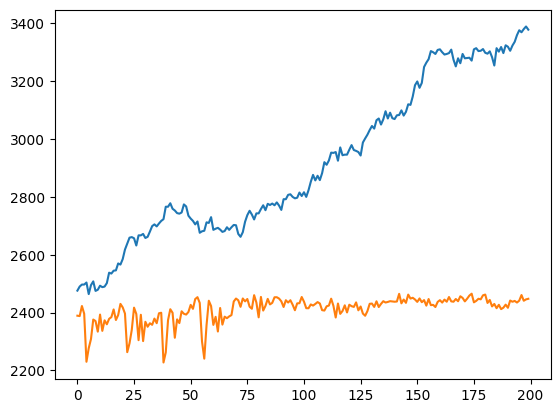

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_valid)
plt.plot(y_valid_pred)
print("len Y_valid: ", len(Y_valid))
print("len y_valid_pred: ", len(y_valid_pred))

### Test evaluation

In [ ]:
# Evaluate model performance using validation set
y_test_pred = model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
mape = mean_absolute_percentage_error(Y_test,y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 8840885.169368748
Mean Absolute Error: 2613.06177292427
Mean Absolute Percentage Error: 48.59740542666632
R^2 Score: -3.3662755339441466


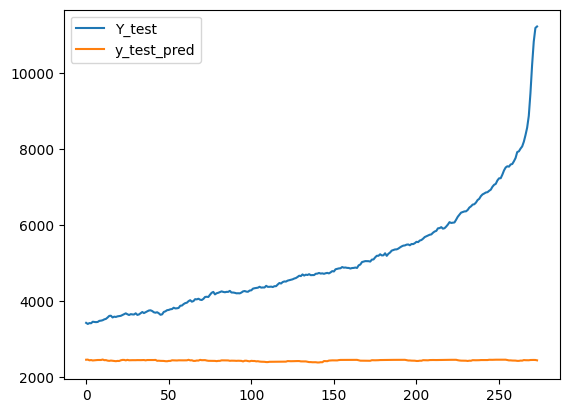

len Y_test:  274
len y_test_pred:  274


In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_test, label="Y_test")
plt.plot(y_test_pred, label="y_test_pred")
plt.legend()
plt.show()
print("len Y_test: ", len(Y_test))
print("len y_test_pred: ", len(y_test_pred))

## Linear Regression

### Train

In [ ]:
filled_X_train = np.nan_to_num(X_train, nan=0)
filled_Y_train = np.nan_to_num(Y_train, nan=0)

LinearRegression()

### Training evaluation

In [ ]:
# Evaluate model performance using validation set

def show_metrics(title, Y_valid, y_valid_pred):
  # Compute evaluation metrics
  mse = mean_squared_error(Y_valid, y_valid_pred)
  mae = mean_absolute_error(Y_valid, y_valid_pred)
  mape = mean_absolute_percentage_error(Y_valid,y_valid_pred)
  r2 = r2_score(Y_valid, y_valid_pred)

  print(title + " METRICS")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Absolute Percentage Error: {mape}")
  print(f"R^2 Score: {r2}")
  print("\n")

lin_reg = ElasticNet()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("ELASTIC NET", Y_valid, y_valid_pred)

lin_reg = Ridge()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("RIDGE", Y_valid, y_valid_pred)

lin_reg = Lasso()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

lin_reg = LinearRegression()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LINEARREGRESSION", Y_valid, y_valid_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


ELASTIC NET METRICS
Mean Squared Error: 8650.905122065371
Mean Absolute Error: 77.2626160361502
Mean Absolute Percentage Error: 10.453345075424734
R^2 Score: 0.882016923245731


RIDGE METRICS
Mean Squared Error: 10496.406626674747
Mean Absolute Error: 84.93137190041278
Mean Absolute Percentage Error: 2.8741793328340433
R^2 Score: 0.8568475400891553


LASSO METRICS
Mean Squared Error: 7441.445704854036
Mean Absolute Error: 71.73662098834977
Mean Absolute Percentage Error: 10.486813797585157
R^2 Score: 0.8985118149638303


LINEARREGRESSION METRICS
Mean Squared Error: 10392.648645706668
Mean Absolute Error: 84.43879344212525
Mean Absolute Percentage Error: 2.858488523659879
R^2 Score: 0.8582626158135671




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


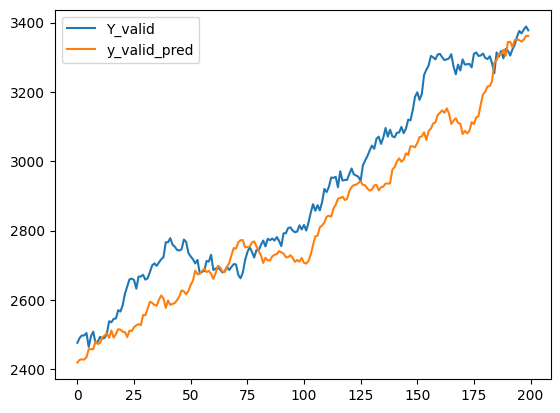

len Y_valid:  200
len y_valid_pred:  200


In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_valid, label="Y_valid")
plt.plot(y_valid_pred, label="y_valid_pred")
plt.legend()
plt.show()
print("len Y_valid: ", len(Y_valid))
print("len y_valid_pred: ", len(y_valid_pred))
# Linear Regression

### Test evaluation

In [ ]:
# Evaluate model performance using validation set
y_test_pred = lin_reg.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
mape = mean_absolute_percentage_error(Y_test,y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 731929.7631942907
Mean Absolute Error: 582.9102026585147
Mean Absolute Percentage Error: 9.947437791764827
R^2 Score: 0.6385195649103821


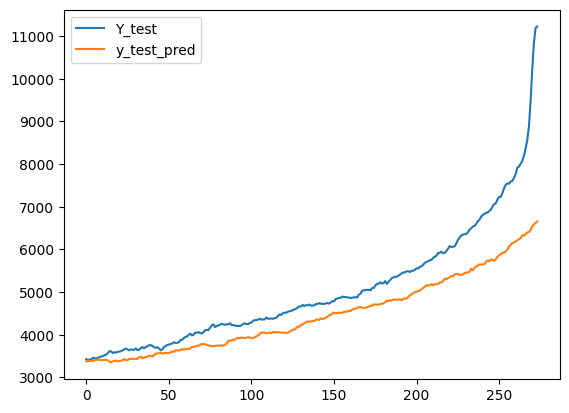

len Y_test:  274
len y_test_pred:  274


In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_test, label="Y_test")
plt.plot(y_test_pred, label="y_test_pred")
plt.legend()
plt.show()
print("len Y_test: ", len(Y_test))
print("len y_test_pred: ", len(y_test_pred))

# Inventory Prediction - Global

## Preprocess

In [250]:
# Raw Y
# Extract Y starting from '2019-01-12' + 30 days until MAX('2024-08-06') - 30, step = 1 day, total days = 30

q = """
SELECT
  DATE_SUB('2023-11-01', INTERVAL 30 DAY),
  DATE_SUB('2023-12-01', INTERVAL 30 DAY),
  DATE_SUB('2024-01-01', INTERVAL 30 DAY),
  DATE_SUB('2024-02-01', INTERVAL 30 DAY)
"""

anchor_dates = bpd.read_gbq(q)
anchor_dates

,f0_,f1_,f2_,f3_
0,2023-10-02,2023-11-01,2023-12-02,2024-01-02


In [ ]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-08-06', INTERVAL 30 DAY))) AS dates
)

SELECT
  EXTRACT(YEAR FROM p.dates) as soldYear,
  EXTRACT(MONTH FROM p.dates) as soldMonth,
  EXTRACT(DAY FROM p.dates) as soldDay,
  soldTotalUser,
  soldTotalEvent,
  soldTotalRetailPrice
FROM placeholder p
LEFT JOIN raw
ON p.dates = raw.soldDate
# WHERE soldTotalEvent IS NULL OR soldTotalEvent = 0
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X[((X['soldYear'] == 2023) & (X['soldMonth'] == 10) & (X['soldDay'] == 2)) |
      ((X['soldYear'] == 2023) & (X['soldMonth'] == 11) & (X['soldDay'] == 1)) |
      ((X['soldYear'] == 2023) & (X['soldMonth'] == 12) & (X['soldDay'] == 2)) |
      ((X['soldYear'] == 2024) & (X['soldMonth'] == 1) & (X['soldDay'] == 2))]

# Take the leftmost index and then use that to filter X_columize
#    index anchor_date  productSoldNextMonth
# 0      2  2023-10-02                  3678
# 1      3  2023-11-01                  3808
# 2      6  2023-12-02                  4243
# 3      0  2024-01-02                  4437
print(X)

      index  soldYear  soldMonth  soldDay  soldTotalUser  soldTotalEvent  \
1724    250      2023         10        2             75             104   
1754    833      2023         11        1             96             135   
1785   1464      2023         12        2             78             111   
1816   1954      2024          1        2             82             121   

      soldTotalRetailPrice  
1724           5150.039988  
1754           8137.740012  
1785           6269.069996  
1816           7962.400011  

[4 rows x 7 columns]


In [153]:
X_selected = np.array(X_columize)[[1724, 1754, 1785, 1816]]
Y_selected = np.array(Y)[[1724, 1754, 1785, 1816]]

In [177]:
y_test_pred = lin_reg.predict(X_selected)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred
Y_selected = Y_selected.reshape(-1)

## Result

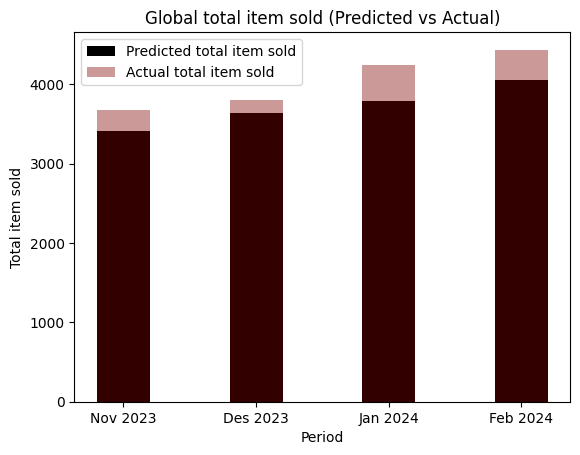

In [190]:
tick_label=list(["Nov 2023", "Des 2023", "Jan 2024", "Feb 2024"])

plt.bar(tick_label, y_test_pred, color ='black',
        width = 0.4, alpha=1, label='Predicted total item sold')
plt.bar(tick_label, Y_selected, color ='maroon',
        width = 0.4, alpha=0.4, label='Actual total item sold')

plt.legend()
plt.title('Global total item sold (Predicted vs Actual)')
plt.xlabel('Period')
plt.ylabel('Total item sold')

# Show the plot
plt.show()

# Inventory Prediction - China

## Preprocess

In [288]:
q = """
  SELECT
    MIN(shipped_at) as min_shipped_at,
    MAX(shipped_at) as max_shipped_at
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'China'
"""

X = bpd.read_gbq(q)
X.head()

,min_shipped_at,max_shipped_at
0,2019-02-01 02:59:00+00:00,2024-08-07 16:03:04.602516+00:00


In [252]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'China'
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
  # Generate date array from raw-MIN(date) to raw-MAX(date)
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
),
result AS (
  SELECT
    EXTRACT(YEAR FROM p.dates) as soldYear,
    EXTRACT(MONTH FROM p.dates) as soldMonth,
    EXTRACT(DAY FROM p.dates) as soldDay,
    soldTotalUser,
    soldTotalEvent,
    soldTotalRetailPrice
  FROM placeholder p
  LEFT JOIN raw
  ON p.dates = raw.soldDate
)

SELECT * FROM result
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X.drop(columns=['index'])
X.head()

,soldYear,soldMonth,soldDay,soldTotalUser,soldTotalEvent,soldTotalRetailPrice
0,2019,1,12,<NA>,<NA>,<NA>
1,2019,1,13,<NA>,<NA>,<NA>
2,2019,1,14,<NA>,<NA>,<NA>
3,2019,1,15,<NA>,<NA>,<NA>
4,2019,1,16,<NA>,<NA>,<NA>


In [253]:
import numpy as np

X = np.array(X.to_pandas().astype(float))

X_columize = []

# for i in range(len(X)):
for i in range(len(X)-30):
  row = []
  for day in range(30):
    row=np.concatenate((row, X[i+day]), axis=None)
  X_columize.append(row)

print("X_columize created")
array = np.array(X_columize)
print(array.shape)

X_columize created
(1944, 180)


In [255]:
# Raw Y
# Extract Y starting from '2019-01-12' + 30 days until MAX('2024-08-06') - 30, step = 1 day, total days = 30

q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    EXTRACT(YEAR FROM oi.shipped_at) as soldYear,
    EXTRACT(MONTH FROM oi.shipped_at) as soldMonth,
    EXTRACT(DAY FROM oi.shipped_at) as soldDay,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'China'
  GROUP BY soldDate, soldYear, soldMonth, soldDay
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
)

SELECT
  p.dates as anchor_date,
  SUM(raw.soldTotalEvent) as productSoldNextMonth
FROM placeholder p
LEFT JOIN raw
ON (raw.soldDate BETWEEN DATE_ADD(p.dates, INTERVAL 30 DAY) AND DATE_ADD(p.dates, INTERVAL 60 day))
GROUP BY 1
# HAVING productSoldNextMonth IS NULL
"""

Y = bpd.read_gbq(q)
Y = Y.sort_values(by=['anchor_date'], ascending=True).reset_index()
print(Y.head())
Y = Y.drop(columns=['index','anchor_date'])

   index anchor_date  productSoldNextMonth
0     53  2019-01-12                    19
1    546  2019-01-13                    18
2    736  2019-01-14                    19
3    951  2019-01-15                    19
4    399  2019-01-16                    19

[5 rows x 3 columns]


In [256]:
# Truncate Y
Y = np.array(Y.to_pandas().astype(float))
Y = Y[:len(X_columize)]

In [271]:
# Train test split
# Train=1500 data; Validation = 200; Test = 274
X_train = X_columize[:1500]
X_valid = X_columize[1500:1700]
X_test = X_columize[1700:]

Y_train = Y[:1500]
Y_valid = Y[1500:1700]
Y_test = Y[1700:]

In [272]:
print(len(X_test))
print(len(Y_test))

244
244


In [273]:
X_train = np.nan_to_num(X_train, nan=0)
Y_train = np.nan_to_num(Y_train, nan=0)

X_valid = np.nan_to_num(X_valid, nan=0)
Y_valid = np.nan_to_num(Y_valid, nan=0)

X_test = np.nan_to_num(X_test, nan=0)
Y_test = np.nan_to_num(Y_test, nan=0)

In [260]:
# Evaluate model performance using validation set

def show_metrics(title, Y_valid, y_valid_pred):
  # Compute evaluation metrics
  mse = mean_squared_error(Y_valid, y_valid_pred)
  mae = mean_absolute_error(Y_valid, y_valid_pred)
  mape = mean_absolute_percentage_error(Y_valid,y_valid_pred)
  r2 = r2_score(Y_valid, y_valid_pred)

  print(title + " METRICS")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Absolute Percentage Error: {mape}")
  print(f"R^2 Score: {r2}")
  print("\n")

lin_reg = ElasticNet()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("ELASTIC NET", Y_valid, y_valid_pred)

lin_reg = Ridge()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("RIDGE", Y_valid, y_valid_pred)

lin_reg = Lasso()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

# lin_reg = LinearRegression()
# lin_reg.fit(filled_X_train,filled_Y_train)
# y_valid_pred = lin_reg.predict(X_valid)
# show_metrics("LINEARREGRESSION", Y_valid, y_valid_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


ELASTIC NET METRICS
Mean Squared Error: 5324.960999162833
Mean Absolute Error: 63.12240265388075
Mean Absolute Percentage Error: 10.782819002950706
R^2 Score: 0.31972136718037525


RIDGE METRICS
Mean Squared Error: 11809.443913679612
Mean Absolute Error: 95.41185053807835
Mean Absolute Percentage Error: 9.894570913903088
R^2 Score: -0.508689427250459


LASSO METRICS
Mean Squared Error: 4493.832332899483
Mean Absolute Error: 58.54409805086831
Mean Absolute Percentage Error: 10.428739619577566
R^2 Score: 0.4259003744767139




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


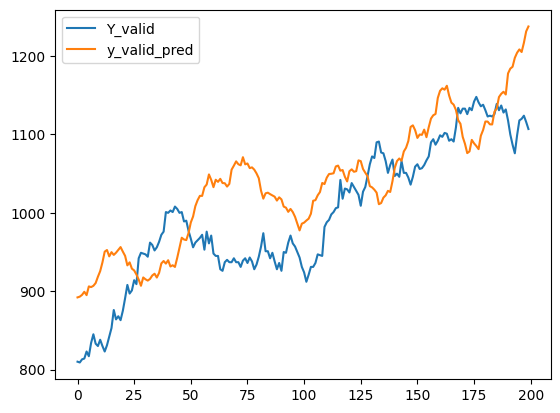

len Y_valid:  200
len y_valid_pred:  200


In [261]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_valid, label="Y_valid")
plt.plot(y_valid_pred, label="y_valid_pred")
plt.legend()
plt.show()
print("len Y_valid: ", len(Y_valid))
print("len y_valid_pred: ", len(y_valid_pred))
# LASSO

In [269]:
len(X_test)

1500

In [274]:
# Evaluate model performance using validation set
y_test_pred = lin_reg.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
mape = mean_absolute_percentage_error(Y_test,y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 7773.342531618829
Mean Absolute Error: 69.51737506478214
Mean Absolute Percentage Error: 19.58296551466097
R^2 Score: 0.910425173017237


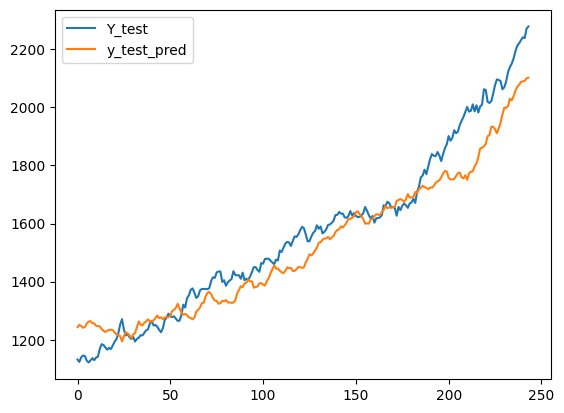

len Y_test:  244
len y_test_pred:  244


In [275]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_test, label="Y_test")
plt.plot(y_test_pred, label="y_test_pred")
plt.legend()
plt.show()
print("len Y_test: ", len(Y_test))
print("len y_test_pred: ", len(y_test_pred))

In [303]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'China'
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-08-06', INTERVAL 30 DAY))) AS dates
)

SELECT
  EXTRACT(YEAR FROM p.dates) as soldYear,
  EXTRACT(MONTH FROM p.dates) as soldMonth,
  EXTRACT(DAY FROM p.dates) as soldDay,
  soldTotalUser,
  soldTotalEvent,
  soldTotalRetailPrice
FROM placeholder p
LEFT JOIN raw
ON p.dates = raw.soldDate
# WHERE soldTotalEvent IS NULL OR soldTotalEvent = 0
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X[((X['soldYear'] == 2023) & (X['soldMonth'] == 10) & (X['soldDay'] == 2)) |
      ((X['soldYear'] == 2023) & (X['soldMonth'] == 11) & (X['soldDay'] == 1)) |
      ((X['soldYear'] == 2023) & (X['soldMonth'] == 12) & (X['soldDay'] == 2)) |
      ((X['soldYear'] == 2024) & (X['soldMonth'] == 1) & (X['soldDay'] == 2))]

# Take the leftmost index and then use that to filter X_columize
#    index anchor_date  productSoldNextMonth
# 0      2  2023-10-02                  3678
# 1      3  2023-11-01                  3808
# 2      6  2023-12-02                  4243
# 3      0  2024-01-02                  4437
print(X)

      index  soldYear  soldMonth  soldDay  soldTotalUser  soldTotalEvent  \
1724    888      2023         10        2             21              28   
1754    764      2023         11        1             47              68   
1785    446      2023         12        2             22              32   
1816    751      2024          1        2             31              52   

      soldTotalRetailPrice  
1724           1134.529997  
1754           3999.860007  
1785           1624.420004  
1816           4107.020025  

[4 rows x 7 columns]


In [277]:
X_selected = np.array(X_columize)[[1724, 1754, 1785, 1816]]
Y_selected = np.array(Y)[[1724, 1754, 1785, 1816]]

In [278]:
y_test_pred = lin_reg.predict(X_selected)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred
Y_selected = Y_selected.reshape(-1)

## Result

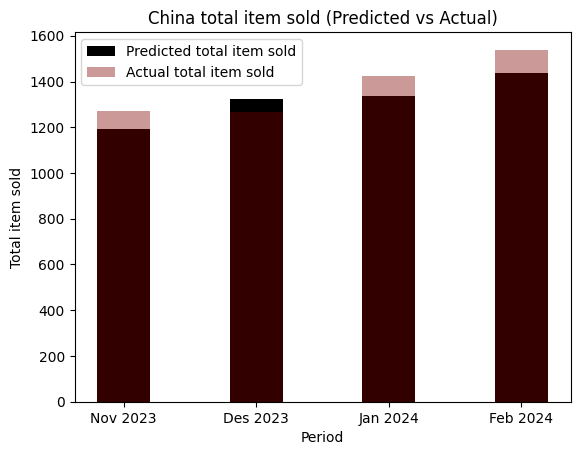

In [284]:
tick_label=list(["Nov 2023", "Des 2023", "Jan 2024", "Feb 2024"])

plt.bar(tick_label, y_test_pred, color ='black',
        width = 0.4, alpha=1, label='Predicted total item sold')
plt.bar(tick_label, Y_selected, color ='maroon',
        width = 0.4, alpha=0.4, label='Actual total item sold')

plt.legend()
plt.title('China total item sold (Predicted vs Actual)')
plt.xlabel('Period')
plt.ylabel('Total item sold')
# Show the plot
plt.show()

# Inventory Prediction - USA

## Preprocess

In [336]:
# Raw X
q = """
  SELECT
    MIN(shipped_at) as min_shipped_at,
    MAX(shipped_at) as max_shipped_at
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'United States'
"""

X = bpd.read_gbq(q)
X.head()

,min_shipped_at,max_shipped_at
0,2019-02-05 12:39:00+00:00,2024-08-07 15:26:08.827343+00:00


In [337]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'United States'
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
  # Generate date array from raw-MIN(date) to raw-MAX(date)
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
),
result AS (
  SELECT
    EXTRACT(YEAR FROM p.dates) as soldYear,
    EXTRACT(MONTH FROM p.dates) as soldMonth,
    EXTRACT(DAY FROM p.dates) as soldDay,
    soldTotalUser,
    soldTotalEvent,
    soldTotalRetailPrice
  FROM placeholder p
  LEFT JOIN raw
  ON p.dates = raw.soldDate
)

SELECT * FROM result
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X.drop(columns=['index'])
X.head()

,soldYear,soldMonth,soldDay,soldTotalUser,soldTotalEvent,soldTotalRetailPrice
0,2019,1,12,<NA>,<NA>,<NA>
1,2019,1,13,<NA>,<NA>,<NA>
2,2019,1,14,<NA>,<NA>,<NA>
3,2019,1,15,<NA>,<NA>,<NA>
4,2019,1,16,<NA>,<NA>,<NA>


In [338]:
import numpy as np

X = np.array(X.to_pandas().astype(float))

X_columize = []

# for i in range(len(X)):
for i in range(len(X)-30):
  row = []
  for day in range(30):
    row=np.concatenate((row, X[i+day]), axis=None)
  X_columize.append(row)

print("X_columize created")
array = np.array(X_columize)
print(array.shape)

X_columize created
(1944, 180)


In [339]:
# Raw Y
# Extract Y starting from '2019-01-12' + 30 days until MAX('2024-08-06') - 30, step = 1 day, total days = 30

q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    EXTRACT(YEAR FROM oi.shipped_at) as soldYear,
    EXTRACT(MONTH FROM oi.shipped_at) as soldMonth,
    EXTRACT(DAY FROM oi.shipped_at) as soldDay,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'United States'
  GROUP BY soldDate, soldYear, soldMonth, soldDay
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
)

SELECT
  p.dates as anchor_date,
  SUM(raw.soldTotalEvent) as productSoldNextMonth
FROM placeholder p
LEFT JOIN raw
ON (raw.soldDate BETWEEN DATE_ADD(p.dates, INTERVAL 30 DAY) AND DATE_ADD(p.dates, INTERVAL 60 day))
GROUP BY 1
"""

Y = bpd.read_gbq(q)
Y = Y.sort_values(by=['anchor_date'], ascending=True).reset_index()
print(Y.head())
Y = Y.drop(columns=['index','anchor_date'])

   index anchor_date  productSoldNextMonth
0   1079  2019-01-12                     5
1    423  2019-01-13                     5
2   1335  2019-01-14                     5
3   1507  2019-01-15                     5
4   1524  2019-01-16                     5

[5 rows x 3 columns]


In [340]:
# Truncate Y
Y = np.array(Y.to_pandas().astype(float))
Y = Y[:len(X_columize)]

In [341]:
# Train test split
# Train=1500 data; Validation = 200; Test = 274
X_train = X_columize[:1500]
X_valid = X_columize[1500:1700]
X_test = X_columize[1700:]

Y_train = Y[:1500]
Y_valid = Y[1500:1700]
Y_test = Y[1700:]

In [342]:
print(len(X_test))
print(len(Y_test))

244
244


In [343]:
X_train = np.nan_to_num(X_train, nan=0)
Y_train = np.nan_to_num(Y_train, nan=0)

X_valid = np.nan_to_num(X_valid, nan=0)
Y_valid = np.nan_to_num(Y_valid, nan=0)

X_test = np.nan_to_num(X_test, nan=0)
Y_test = np.nan_to_num(Y_test, nan=0)

In [347]:
# Evaluate model performance using validation set

def show_metrics(title, Y_valid, y_valid_pred):
  # Compute evaluation metrics
  mse = mean_squared_error(Y_valid, y_valid_pred)
  mae = mean_absolute_error(Y_valid, y_valid_pred)
  mape = mean_absolute_percentage_error(Y_valid,y_valid_pred)
  r2 = r2_score(Y_valid, y_valid_pred)

  print(title + " METRICS")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Absolute Percentage Error: {mape}")
  print(f"R^2 Score: {r2}")
  print("\n")

lin_reg = ElasticNet()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("ELASTIC NET", Y_valid, y_valid_pred)

lin_reg = Ridge()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("RIDGE", Y_valid, y_valid_pred)

lin_reg = Lasso(max_iter=10000)
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

lin_reg = LinearRegression()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LINEARREGRESSION", Y_valid, y_valid_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


ELASTIC NET METRICS
Mean Squared Error: 4741.614983667924
Mean Absolute Error: 62.72353959734115
Mean Absolute Percentage Error: 14.321634591939873
R^2 Score: -0.4081630369635094


RIDGE METRICS
Mean Squared Error: 14423.295595006353
Mean Absolute Error: 115.51550568010964
Mean Absolute Percentage Error: 17.23906553929255
R^2 Score: -3.283424908611048


LASSO METRICS
Mean Squared Error: 3794.7701098741277
Mean Absolute Error: 56.16145096160344
Mean Absolute Percentage Error: 13.692064920183366
R^2 Score: -0.1269694019663028


LINEARREGRESSION METRICS
Mean Squared Error: 14213.133139174297
Mean Absolute Error: 114.4176151714455
Mean Absolute Percentage Error: 17.06968919785485
R^2 Score: -3.2210109414122075




In [348]:
lin_reg = Lasso(max_iter=10000)
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

LASSO METRICS
Mean Squared Error: 3794.7701098741277
Mean Absolute Error: 56.16145096160344
Mean Absolute Percentage Error: 13.692064920183366
R^2 Score: -0.1269694019663028




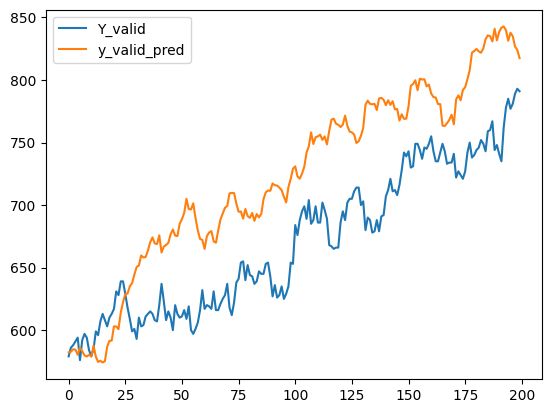

len Y_valid:  200
len y_valid_pred:  200


In [349]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_valid, label="Y_valid")
plt.plot(y_valid_pred, label="y_valid_pred")
plt.legend()
plt.show()
print("len Y_valid: ", len(Y_valid))
print("len y_valid_pred: ", len(y_valid_pred))
# LASSO

In [350]:
# Evaluate model performance using validation set
y_test_pred = lin_reg.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
mape = mean_absolute_percentage_error(Y_test,y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 4051.3682183579112
Mean Absolute Error: 48.612305592855456
Mean Absolute Percentage Error: 20.347365592304786
R^2 Score: 0.9048301387413665


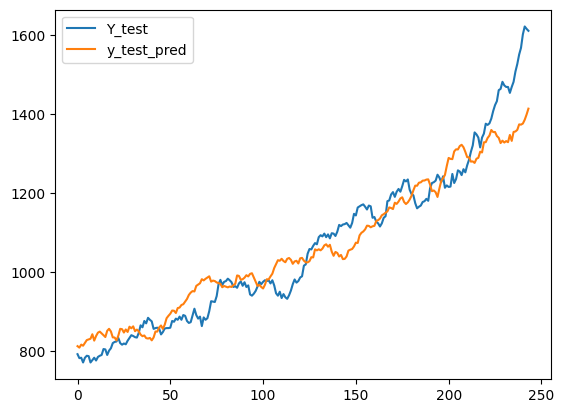

len Y_test:  244
len y_test_pred:  244


In [351]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_test, label="Y_test")
plt.plot(y_test_pred, label="y_test_pred")
plt.legend()
plt.show()
print("len Y_test: ", len(Y_test))
print("len y_test_pred: ", len(y_test_pred))

In [352]:
X_selected = np.array(X_columize)[[1724, 1754, 1785, 1816]]
Y_selected = np.array(Y)[[1724, 1754, 1785, 1816]]

In [353]:
y_test_pred = lin_reg.predict(X_selected)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred
Y_selected = Y_selected.reshape(-1)

## Result

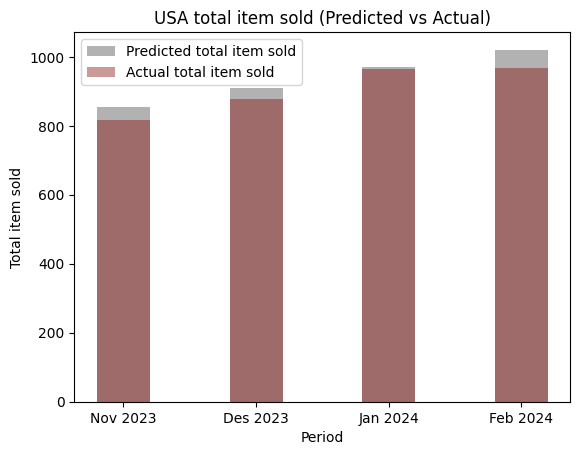

In [354]:
tick_label=list(["Nov 2023", "Des 2023", "Jan 2024", "Feb 2024"])

plt.bar(tick_label, y_test_pred, color ='black',
        width = 0.4, alpha=0.3, label='Predicted total item sold')
plt.bar(tick_label, Y_selected, color ='maroon',
        width = 0.4, alpha=0.4, label='Actual total item sold')

plt.legend()
plt.title('USA total item sold (Predicted vs Actual)')
plt.xlabel('Period')
plt.ylabel('Total item sold')
# Show the plot
plt.show()

# Inventory Prediction - Brasil

## Preprocess

In [312]:
# Raw X
q = """
  SELECT
    MIN(shipped_at) as min_shipped_at,
    MAX(shipped_at) as max_shipped_at
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'Brasil'
"""

X = bpd.read_gbq(q)
X.head()

,min_shipped_at,max_shipped_at
0,2019-01-25 13:44:00+00:00,2024-08-07 08:49:22.476715+00:00


In [313]:
# Raw X
q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'Brasil'
  GROUP BY soldDate
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
  # Generate date array from raw-MIN(date) to raw-MAX(date)
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
),
result AS (
  SELECT
    EXTRACT(YEAR FROM p.dates) as soldYear,
    EXTRACT(MONTH FROM p.dates) as soldMonth,
    EXTRACT(DAY FROM p.dates) as soldDay,
    soldTotalUser,
    soldTotalEvent,
    soldTotalRetailPrice
  FROM placeholder p
  LEFT JOIN raw
  ON p.dates = raw.soldDate
)

SELECT * FROM result
"""

X = bpd.read_gbq(q)
X = X.sort_values(by=['soldYear','soldMonth','soldDay'], ascending=[True,True,True]).reset_index()
X = X.drop(columns=['index'])
X.head()

,soldYear,soldMonth,soldDay,soldTotalUser,soldTotalEvent,soldTotalRetailPrice
0,2019,1,12,<NA>,<NA>,<NA>
1,2019,1,13,<NA>,<NA>,<NA>
2,2019,1,14,<NA>,<NA>,<NA>
3,2019,1,15,<NA>,<NA>,<NA>
4,2019,1,16,<NA>,<NA>,<NA>


In [314]:
import numpy as np

X = np.array(X.to_pandas().astype(float))

X_columize = []

# for i in range(len(X)):
for i in range(len(X)-30):
  row = []
  for day in range(30):
    row=np.concatenate((row, X[i+day]), axis=None)
  X_columize.append(row)

print("X_columize created")
array = np.array(X_columize)
print(array.shape)

X_columize created
(1944, 180)


In [315]:
# Raw Y
# Extract Y starting from '2019-01-12' + 30 days until MAX('2024-08-06') - 30, step = 1 day, total days = 30

q = """
WITH raw AS (
  SELECT
    EXTRACT(DATE FROM oi.shipped_at) as soldDate,
    EXTRACT(YEAR FROM oi.shipped_at) as soldYear,
    EXTRACT(MONTH FROM oi.shipped_at) as soldMonth,
    EXTRACT(DAY FROM oi.shipped_at) as soldDay,
    COUNT(DISTINCT oi.user_id) as soldTotalUser,
    COUNT(DISTINCT oi.id) as soldTotalEvent,
    SUM(ii.product_retail_price) as soldTotalRetailPrice
  FROM bigquery-public-data.thelook_ecommerce.order_items oi
  JOIN bigquery-public-data.thelook_ecommerce.inventory_items ii
  ON ii.id = oi.inventory_item_id
  JOIN bigquery-public-data.thelook_ecommerce.users u
  ON oi.user_id = u.id
  WHERE oi.shipped_at IS NOT NULL
    AND u.country = 'Brasil'
  GROUP BY soldDate, soldYear, soldMonth, soldDay
),
placeholder AS (
# From minimum date of raw
  SELECT
    dates
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2019-01-12', DATE_SUB('2024-07-07', INTERVAL 30 DAY))) AS dates
)

SELECT
  p.dates as anchor_date,
  SUM(raw.soldTotalEvent) as productSoldNextMonth
FROM placeholder p
LEFT JOIN raw
ON (raw.soldDate BETWEEN DATE_ADD(p.dates, INTERVAL 30 DAY) AND DATE_ADD(p.dates, INTERVAL 60 day))
GROUP BY 1
"""

Y = bpd.read_gbq(q)
Y = Y.sort_values(by=['anchor_date'], ascending=True).reset_index()
print(Y.head())
Y = Y.drop(columns=['index','anchor_date'])

   index anchor_date  productSoldNextMonth
0     12  2019-01-12                     8
1    140  2019-01-13                     8
2    404  2019-01-14                     8
3   1850  2019-01-15                     8
4   1025  2019-01-16                     8

[5 rows x 3 columns]


In [316]:
# Truncate Y
Y = np.array(Y.to_pandas().astype(float))
Y = Y[:len(X_columize)]

In [317]:
# Train test split
# Train=1500 data; Validation = 200; Test = 274
X_train = X_columize[:1500]
X_valid = X_columize[1500:1700]
X_test = X_columize[1700:]

Y_train = Y[:1500]
Y_valid = Y[1500:1700]
Y_test = Y[1700:]

In [318]:
print(len(X_test))
print(len(Y_test))

244
244


In [319]:
X_train = np.nan_to_num(X_train, nan=0)
Y_train = np.nan_to_num(Y_train, nan=0)

X_valid = np.nan_to_num(X_valid, nan=0)
Y_valid = np.nan_to_num(Y_valid, nan=0)

X_test = np.nan_to_num(X_test, nan=0)
Y_test = np.nan_to_num(Y_test, nan=0)

In [326]:
# Evaluate model performance using validation set

def show_metrics(title, Y_valid, y_valid_pred):
  # Compute evaluation metrics
  mse = mean_squared_error(Y_valid, y_valid_pred)
  mae = mean_absolute_error(Y_valid, y_valid_pred)
  mape = mean_absolute_percentage_error(Y_valid,y_valid_pred)
  r2 = r2_score(Y_valid, y_valid_pred)

  print(title + " METRICS")
  print(f"Mean Squared Error: {mse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Absolute Percentage Error: {mape}")
  print(f"R^2 Score: {r2}")
  print("\n")

lin_reg = ElasticNet()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("ELASTIC NET", Y_valid, y_valid_pred)

lin_reg = Ridge()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("RIDGE", Y_valid, y_valid_pred)

lin_reg = Lasso(max_iter=5000)
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

lin_reg = LinearRegression()
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LINEARREGRESSION", Y_valid, y_valid_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+06, tolerance: 6.596e+04
  model = cd_fast.enet_coordinate_descent(


ELASTIC NET METRICS
Mean Squared Error: 8039.038158466483
Mean Absolute Error: 83.50559668068534
Mean Absolute Percentage Error: 25.10894570088798
R^2 Score: -1.45443798490422


RIDGE METRICS
Mean Squared Error: 22705.588216323773
Mean Absolute Error: 147.35120676394325
Mean Absolute Percentage Error: 35.995374458731234
R^2 Score: -5.932353981806401


LASSO METRICS
Mean Squared Error: 6534.7547685669015
Mean Absolute Error: 73.9905160526227
Mean Absolute Percentage Error: 23.712098906946753
R^2 Score: -0.9951578795670495


LINEARREGRESSION METRICS
Mean Squared Error: 22301.83835455941
Mean Absolute Error: 145.92465902873607
Mean Absolute Percentage Error: 35.64128687723363
R^2 Score: -5.809083140496783




In [327]:
lin_reg = Lasso(max_iter=5000)
lin_reg.fit(filled_X_train,filled_Y_train)
y_valid_pred = lin_reg.predict(X_valid)
show_metrics("LASSO", Y_valid, y_valid_pred)

LASSO METRICS
Mean Squared Error: 6534.7547685669015
Mean Absolute Error: 73.9905160526227
Mean Absolute Percentage Error: 23.712098906946753
R^2 Score: -0.9951578795670495




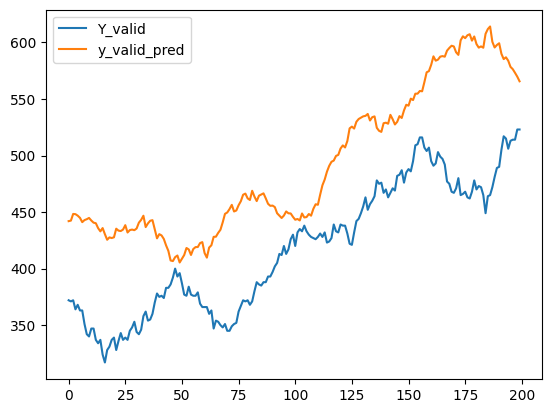

len Y_valid:  200
len y_valid_pred:  200


In [328]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_valid, label="Y_valid")
plt.plot(y_valid_pred, label="y_valid_pred")
plt.legend()
plt.show()
print("len Y_valid: ", len(Y_valid))
print("len y_valid_pred: ", len(y_valid_pred))
# LASSO

In [329]:
# Evaluate model performance using validation set
y_test_pred = lin_reg.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(Y_test, y_test_pred)
mae = mean_absolute_error(Y_test, y_test_pred)
mape = mean_absolute_percentage_error(Y_test,y_test_pred)
r2 = r2_score(Y_test, y_test_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 3903.7656437449887
Mean Absolute Error: 50.40817277504628
Mean Absolute Percentage Error: 20.96935566524393
R^2 Score: 0.7949196707492712


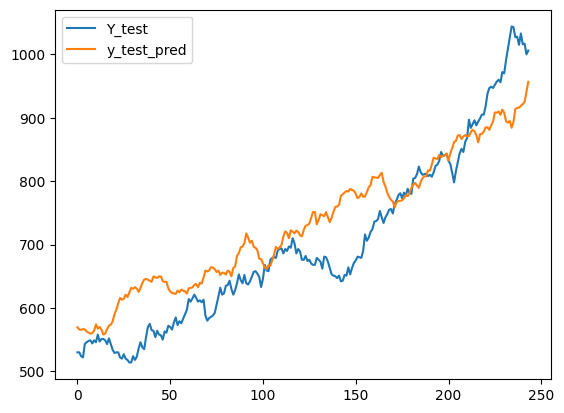

len Y_test:  244
len y_test_pred:  244


In [330]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.plot(Y_test, label="Y_test")
plt.plot(y_test_pred, label="y_test_pred")
plt.legend()
plt.show()
print("len Y_test: ", len(Y_test))
print("len y_test_pred: ", len(y_test_pred))

In [331]:
X_selected = np.array(X_columize)[[1724, 1754, 1785, 1816]]
Y_selected = np.array(Y)[[1724, 1754, 1785, 1816]]

In [332]:
y_test_pred = lin_reg.predict(X_selected)
y_test_pred = y_test_pred.reshape(-1)
y_test_pred
Y_selected = Y_selected.reshape(-1)

## Result

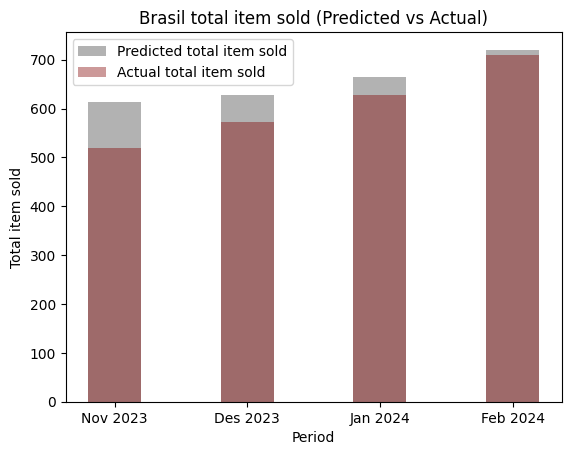

In [334]:
tick_label=list(["Nov 2023", "Des 2023", "Jan 2024", "Feb 2024"])

plt.bar(tick_label, y_test_pred, color ='black',
        width = 0.4, alpha=0.3, label='Predicted total item sold')
plt.bar(tick_label, Y_selected, color ='maroon',
        width = 0.4, alpha=0.4, label='Actual total item sold')

plt.legend()
plt.title('Brasil total item sold (Predicted vs Actual)')
plt.xlabel('Period')
plt.ylabel('Total item sold')
# Show the plot
plt.show()